In [44]:
#%matplotlib notebook
%matplotlib inline
from matplotlib import rc
rc('figure',figsize=(16,8))
rc('font',size=12)
rc('text',usetex=False)

from qubicpack import qubicpack as qp
import fibtools as ft
import plotters as p
import lin_lib as ll
import demodulation_lib as dl

from pysimulators import FitsArray

import numpy as np
from matplotlib.pyplot import *
import matplotlib.mlab as mlab
import scipy.ndimage.filters as f
import glob
import string
import scipy.signal as scsig
from scipy import interpolate

## Dataset
Between March 13th 2019 and March 17th 2019 we have performed 4 series of scans, each starting at -XX in elevation (w.r.t. rest position==50 deg.) and then making 40 azimuth scans, each from -20 to 20 degrees. After each azimuth scan, the elevation is increased by 1 degree (not encoder degrees, only step motors, so with a significant uncertainty, but Louise has done some calibration of this).

Here is a description of each dataset:
1. "ScanMap": from 2019-03-13 @ 19h21 to 2019-03-14 @ 11h03 
    - First scan from -20 in elevation to +20, therefore actual elevation from 30 to 70
    - To be analyzed
2. "ScanMapNew": from 2019-03-14 @ 13h22 to 15h34, then 2019-03-15 @ 13h42 to 14h13
    - Many GPS issues with this scan
    - finally interrupted. 
    - Not to be analaysed in priority
3. "ScanMapNew2": from 2019-03-15 @ 17h21 to 2019-03-16 @ 9h17
    - Scan from -20 in elevation to +20, therefore actual elevation from 30 to 70
    - Cycle finished at scan 38 or 39 => take care of this
    - to be analysed
4. "ScanMapNew2_Start_40.5": from 2019-03-16 @ 20h17 to 2019-03-17 @ 12h15
    - Scan started at el-19.5 to + 20.5: therefore actual elevation 30.5 to 70.5
    - to be analyzed
    
Lets get the directories corresponding to each dataset:

In [27]:
names = ['ScanMap', 'ScanMapNew2', 'ScanMapNew2_start-40.5']
days = [['2019-03-13', '2019-03-14'], ['2019-03-15', '2019-03-16'], ['2019-03-16', '2019-03-17']]
el_start = [30., 30., 30.5]
delta_el = 1.

all_elevation = []
datasets=[]
for inames in xrange(len(names)):
    n = names[inames]
    print n, ' Elevation starts at {}'.format(el_start[inames])
    datasets.append([])
    for d in days[inames]:
        dd = glob.glob('/qubic/Data/Calib-TD/'+d+'/*'+n)
        for i in xrange(len(dd)): 
            datasets[inames].append(dd[i])
        print '  * ',d,' : {} files'.format(len(dd))
    print '  => Total = {} files'.format(len(datasets[inames]))
    elevations = el_start[inames]+arange(len(datasets[inames]))*delta_el
    all_elevation.append(elevations)
    print '  => Elevation ends at {}'.format(np.max(elevations))


ScanMap  Elevation starts at 30.0
  *  2019-03-13  : 12 files
  *  2019-03-14  : 29 files
  => Total = 41 files
  => Elevation ends at 70.0
ScanMapNew2  Elevation starts at 30.0
  *  2019-03-15  : 17 files
  *  2019-03-16  : 24 files
  => Total = 41 files
  => Elevation ends at 70.0
ScanMapNew2_start-40.5  Elevation starts at 30.5
  *  2019-03-16  : 10 files
  *  2019-03-17  : 31 files
  => Total = 41 files
  => Elevation ends at 70.5


We start with the forst dataset ('ScanMap'):

In [116]:
index = 1
dirs = datasets[index]
elevation = all_elevation[index]

labels = []
dir_time = []
for d in dirs:
    bla = str.split(d,'__')
    blo = str.split(bla[0],'/')
    labels.append(bla[1])
    dir_time.append(blo[-1])
    
for i in xrange(len(labels)): 
    print labels[i], dir_time[i], 'Elevation: ', elevation[i]


ScanMapNew2 2019-03-15_17.21.10 Elevation:  30.0
ScanMapNew2 2019-03-15_17.45.00 Elevation:  31.0
ScanMapNew2 2019-03-15_18.08.53 Elevation:  32.0
ScanMapNew2 2019-03-15_18.33.20 Elevation:  33.0
ScanMapNew2 2019-03-15_18.57.13 Elevation:  34.0
ScanMapNew2 2019-03-15_19.21.06 Elevation:  35.0
ScanMapNew2 2019-03-15_19.45.27 Elevation:  36.0
ScanMapNew2 2019-03-15_20.09.12 Elevation:  37.0
ScanMapNew2 2019-03-15_20.33.49 Elevation:  38.0
ScanMapNew2 2019-03-15_20.57.42 Elevation:  39.0
ScanMapNew2 2019-03-15_21.21.17 Elevation:  40.0
ScanMapNew2 2019-03-15_21.45.09 Elevation:  41.0
ScanMapNew2 2019-03-15_22.08.38 Elevation:  42.0
ScanMapNew2 2019-03-15_22.32.30 Elevation:  43.0
ScanMapNew2 2019-03-15_22.56.22 Elevation:  44.0
ScanMapNew2 2019-03-15_23.20.43 Elevation:  45.0
ScanMapNew2 2019-03-15_23.44.26 Elevation:  46.0
ScanMapNew2 2019-03-16_00.08.20 Elevation:  47.0
ScanMapNew2 2019-03-16_00.32.14 Elevation:  48.0
ScanMapNew2 2019-03-16_00.56.08 Elevation:  49.0
ScanMapNew2 2019-03-

## Reading TES data

In [117]:
import scipy.signal
write_dir = '/Volumes/Data/Qubic/Calib-TD/ScansNightDay/'

AsicNum = 1
TESnum = 96

for idir in xrange(len(dirs)):
    print '################## Dir {} / {} ################'.format(idir,len(dirs))
    thedir = dirs[idir]

    #### Read data
    a = qp()
    a.read_qubicstudio_dataset(thedir, asic=AsicNum)
    TESNum = 96
    data = a.timeline(TES=TESNum)
    t_data = a.timeline_timeaxis(axistype='pps')

    #### Power Spectrum
    FREQ_SAMPLING = 1./(t_data[1]-t_data[0])
    spectrum_f, freq_f = mlab.psd(data, Fs=FREQ_SAMPLING, NFFT=len(data)/10, window=mlab.window_hanning)

    FitsArray(freq_f).save(write_dir+labels[idir]+'_'+str(100+idir)+'_'+dir_time[idir]+'_PS_freq.fits')
    FitsArray(spectrum_f).save(write_dir+labels[idir]+'_'+str(100+idir)+'_'+dir_time[idir]+'_PS_spec.fits')

    #### Time/Freq Analysis
    f, t, Sxx = scipy.signal.spectrogram(data, fs=FREQ_SAMPLING, window=('tukey', 0.25), 
                                   nperseg=1024, noverlap=None, nfft=None, 
                                   detrend='constant', return_onesided=True, 
                                   scaling='density', axis=-1, mode='psd')

    FitsArray(f).save(write_dir+labels[idir]+'_'+str(100+idir)+'_'+dir_time[idir]+'_TimeFreq_freq.fits')
    FitsArray(t).save(write_dir+labels[idir]+'_'+str(100+idir)+'_'+dir_time[idir]+'_TimeFreq_time.fits')
    FitsArray(Sxx).save(write_dir+labels[idir]+'_'+str(100+idir)+'_'+dir_time[idir]+'_TimeFreq_spec.fits')



################## Dir 0 / 41 ################
Reading data for ASIC 1
reading fits file: /qubic/Data/Calib-TD/2019-03-15/2019-03-15_17.21.10__ScanMapNew2/Sums/science-asic1-2019.03.15.172110.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-15/2019-03-15_17.21.10__ScanMapNew2/Sums/science-asic1-2019.03.15.172110.fits
Guessing the detector array is: P87
No MMR data found in directory: /qubic/Data/Calib-TD/2019-03-15/2019-03-15_17.21.10__ScanMapNew2/Hks
reading fits file: /qubic/Data/Calib-TD/2019-03-15/2019-03-15_17.21.10__ScanMapNew2/Hks/hk-intern-2019.03.15.172110.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-15/2019-03-15_17.21.10__ScanMapNew2/Hks/hk-intern-2019.03.15.172110.fits
reading fits file: /qubic/Data/Calib-TD/2019-03-15/2019-03-15_17.21.10__ScanMapNew2/Hks/conf-asics-2019.03.15.172111.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-15/2019-03-15_17.21.10__ScanMapNew2/Hks/conf-asics-2019.03.15.172111.fits
There are 280 hous

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:19: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python2.7/site-packages/numpy/fft/helper.py:162: RuntimeWarning: divide by zero encountered in double_scalars
  val = 1.0 / (n * d)
//anaconda/lib/python2.7/site-packages/numpy/fft/helper.py:169: RuntimeWarning: invalid value encountered in multiply
  return results * val
//anaconda/lib/python2.7/site-packages/numpy/fft/helper.py:218: RuntimeWarning: divide by zero encountered in double_scalars
  val = 1.0/(n*d)



################## Dir 1 / 41 ################
Reading data for ASIC 1
reading fits file: /qubic/Data/Calib-TD/2019-03-15/2019-03-15_17.45.00__ScanMapNew2/Sums/science-asic1-2019.03.15.174500.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-15/2019-03-15_17.45.00__ScanMapNew2/Sums/science-asic1-2019.03.15.174500.fits
Guessing the detector array is: P87
No MMR data found in directory: /qubic/Data/Calib-TD/2019-03-15/2019-03-15_17.45.00__ScanMapNew2/Hks
reading fits file: /qubic/Data/Calib-TD/2019-03-15/2019-03-15_17.45.00__ScanMapNew2/Hks/hk-intern-2019.03.15.174500.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-15/2019-03-15_17.45.00__ScanMapNew2/Hks/hk-intern-2019.03.15.174500.fits
reading fits file: /qubic/Data/Calib-TD/2019-03-15/2019-03-15_17.45.00__ScanMapNew2/Hks/conf-asics-2019.03.15.174503.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-15/2019-03-15_17.45.00__ScanMapNew2/Hks/conf-asics-2019.03.15.174503.fits
There are 280 hou

//anaconda/lib/python2.7/site-packages/numpy/fft/helper.py:221: RuntimeWarning: invalid value encountered in multiply
  return results * val
//anaconda/lib/python2.7/site-packages/qubicpack-2.0.0-py2.7.egg/qubicpack/tools.py:808: RuntimeWarning: Mean of empty slice.
  mean_separation = separations.mean()



Using TES temperature 370.9mK
Bad PPS Data!


//anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


ValueError: cannot convert float NaN to integer

In [54]:
print('fini !')

fini !


### Now Analyse

In [101]:
allf = []
allspec = []
allf2d = []
allt2d = []
alltf = []
for idir in xrange(len(dirs)):
    allf.append(FitsArray(write_dir+labels[idir]+'_'+str(100+idir)+'_'+dir_time[idir]+'_PS_freq.fits'))
    allspec.append(FitsArray(write_dir+labels[idir]+'_'+str(100+idir)+'_'+dir_time[idir]+'_PS_spec.fits'))    
    allf2d.append(FitsArray(write_dir+labels[idir]+'_'+str(100+idir)+'_'+dir_time[idir]+'_TimeFreq_freq.fits'))
    allt2d.append(FitsArray(write_dir+labels[idir]+'_'+str(100+idir)+'_'+dir_time[idir]+'_TimeFreq_time.fits'))
    alltf.append(FitsArray(write_dir+labels[idir]+'_'+str(100+idir)+'_'+dir_time[idir]+'_TimeFreq_spec.fits'))

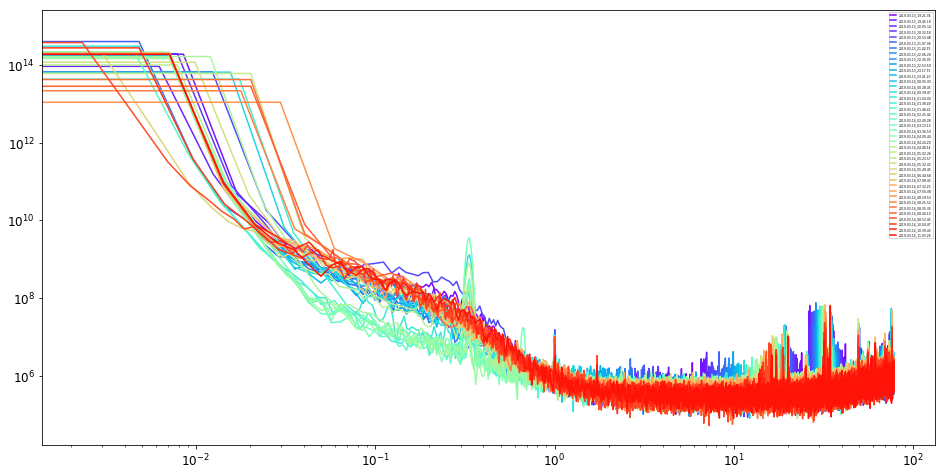

In [102]:
spec_img = np.zeros((len(dirs), 10000))
valfreq = np.linspace(0, FREQ_SAMPLING/2, 10000)
valfreq = np.logspace(-1, np.log10(FREQ_SAMPLING/2), 10000)

for i in xrange(len(dirs)):
    plot(allf[i], allspec[i], label=dir_time[i], color=cm.rainbow(i*1./len(dirs)))
    spec_img[i,:] = np.interp(valfreq, allf[i], allspec[i])
    
xscale('log')
yscale('log')
legend(fontsize=3)

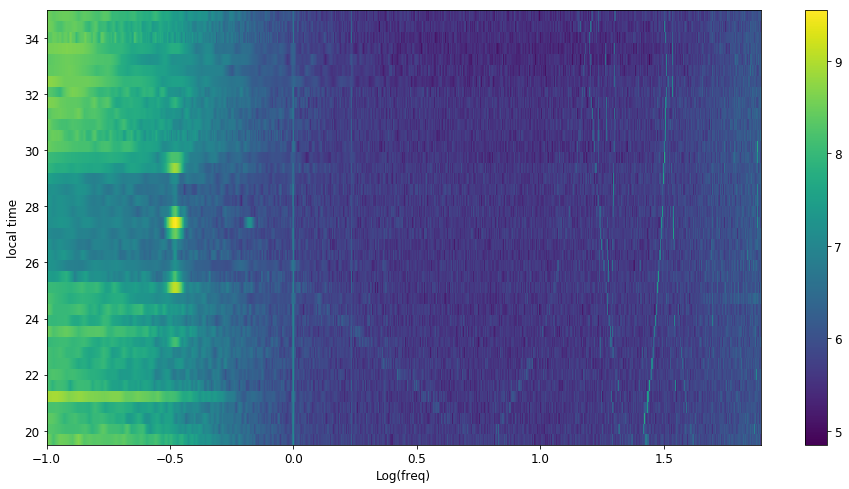

In [103]:
time = np.linspace(19.5, 11.+24, 41)
pcolormesh(np.log10(valfreq), time, np.log10(spec_img))
xlabel('Log(freq)')
ylabel('local time')
colorbar()

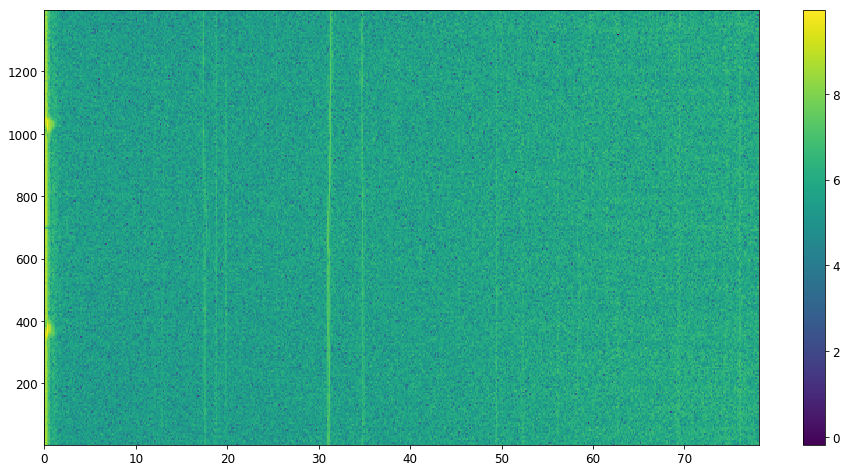

In [115]:
ii=20
pcolormesh(np.array(allf2d[ii]), np.array(allt2d[ii]), np.log10(np.array(alltf[ii].T)))
colorbar()